In [ ]:
'!unzip /content/drive/MyDrive/APS360Project/archive/cropped_dataset/A.zip

Archive:  /content/drive/MyDrive/APS360Project/archive/cropped_dataset/A.zip
replace A/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# initialization
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
import os
drive.mount('/content/drive')
import numpy as np
import time
import pandas as pd
from matplotlib.image import imread
from torchvision.io import read_image
from torchsummary import summary
import torch.optim as optim

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# path declare
master_path = '/content/drive/MyDrive/APS360Project/archive/cropped_dataset/'
csv_path = master_path + "cropped_proportion.csv"
train_csv_path = master_path + "cropped_proportion_train.csv"
val_csv_path = master_path + "cropped_proportion_valid.csv"
test_csv_path = master_path + "cropped_proportion_test.csv"
class_dict_path = master_path + "class_dict.csv"
image_folder_path = '/content/A'
total_info = pd.read_csv(csv_path)
train_info = pd.read_csv(train_csv_path)
val_info = pd.read_csv(val_csv_path)
test_info = pd.read_csv(test_csv_path)

In [ ]:
train_info.head()

,image_id,split,sat_image_path,mask_path,urban_land,agriculture_land,rangeland,forest_land,water,barren_land,unknown
0,100694,train,train/100694_sat_0.jpg,train/100694_mask_0.png,0.0,0.999955,0.000000,0.0,0.0,0.0,0.000045
1,100694,train,train/100694_sat_1.jpg,train/100694_mask_1.png,0.0,0.984039,0.015961,0.0,0.0,0.0,0.000000
2,100694,train,train/100694_sat_2.jpg,train/100694_mask_2.png,0.0,0.999592,0.000408,0.0,0.0,0.0,0.000000
3,100694,train,train/100694_sat_3.jpg,train/100694_mask_3.png,0.0,0.819517,0.180483,0.0,0.0,0.0,0.000000
4,100694,train,train/100694_sat_4.jpg,train/100694_mask_4.png,0.0,1.000000,0.000000,0.0,0.0,0.0,0.000000


In [ ]:
print(len(total_info['image_id']))
print(len(train_info['image_id']), len(train_info['image_id'])/len(total_info['image_id']))
print(len(val_info['image_id']), len(val_info['image_id'])/len(total_info['image_id']))
print(len(test_info['image_id']), len(test_info['image_id'])/len(total_info['image_id']))

12848
9616 0.7484433374844334
1616 0.12577833125778332
1616 0.12577833125778332


In [ ]:
classes = pd.read_csv(class_dict_path)
list(classes['name'])

['urban_land',
 'agriculture_land',
 'rangeland',
 'forest_land',
 'water',
 'barren_land',
 'unknown']

In [ ]:
class DataFull(object):  # Class names typically use CamelCase
    def __init__(self, csv_info, image_folder_path, transform=None):
        self.img_info = csv_info
        self.image_folder_path = image_folder_path
        self.transform = transform

    def __len__(self):
        return len(self.img_info)  # Assuming img_info is a DataFrame or similar structure

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder_path, self.img_info['sat_image_path'][idx])
        image = read_image(img_path)
        label = [self.img_info['urban_land'][idx], self.img_info['agriculture_land'][idx], self.img_info['rangeland'][idx],
                 self.img_info['forest_land'][idx], self.img_info['water'][idx], self.img_info['barren_land'][idx],
                 self.img_info['unknown'][idx]]
        if self.transform:
            image = self.transform(image)
        return image, label
    def sum_labels(self):
        label_sums = [0] * 7  # Adjust the size if the number of labels changes
        for idx in range(len(self)):
            _, label = self.__getitem__(idx)
            # Sum each component of the label
            label_sums = [sum(x) for x in zip(label_sums, label)]
        return label_sums

In [ ]:
# Define the transformation pipeline
transform = transforms.Compose([
    transforms.ToPILImage(),  # If your images are not in PIL Image format
    transforms.Resize((256, 256)),  # Resizing the image
    transforms.ToTensor(),  # Convert the PIL Image to a tensor
    #transforms.Normalize(mean, std)  # Normalize the tensor
])

train_dataset = DataFull(train_info, image_folder_path ,transform=transform)
val_dataset = DataFull(val_info, image_folder_path ,transform=transform)
test_dataset = DataFull(test_info, image_folder_path ,transform=transform)

In [ ]:
print(train_dataset.sum_labels())
print(val_dataset.sum_labels())
print(test_dataset.sum_labels())

[1052.998932034689, 5656.6658096245, 827.8306340510042, 953.0919918621051, 302.64575056602166, 816.8270884061687, 5.939793455508567]
[128.30313928403595, 866.2427965739668, 128.74245482506726, 290.99093297449696, 72.53017268999115, 128.66493923277366, 0.5255644196676488]
[206.72667563757514, 895.0322952710509, 133.44538425391937, 190.0009344696484, 50.41910429749241, 140.26601947968743, 0.109586590627536]


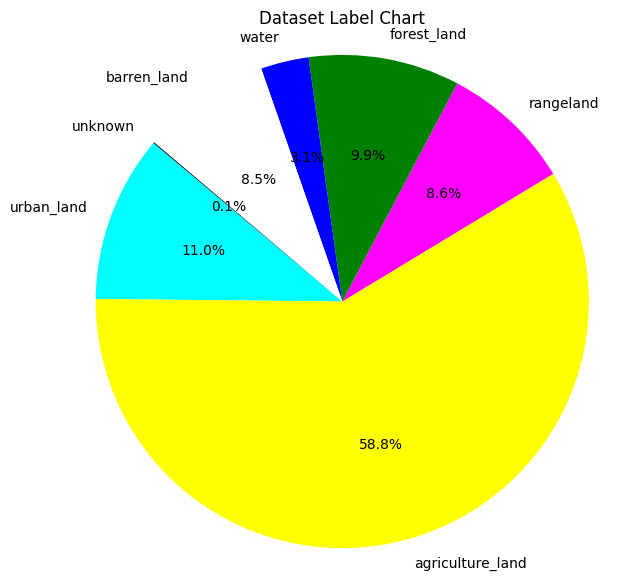

In [1]:
# Create the pie chart
import matplotlib.pyplot as plt

sizes = [1052.998932034689, 5656.6658096245, 827.8306340510042, 953.0919918621051, 302.64575056602166, 816.8270884061687, 5.939793455508567]
labels = ['urban_land',
 'agriculture_land',
 'rangeland',
 'forest_land',
 'water',
 'barren_land',
 'unknown']  # Labels for each segment

colors = ['cyan', 'yellow', 'magenta', 'green', "blue", "white", "black"]

# Create the pie chart
plt.figure(figsize=(7, 7))  # Optional: Specifies the figure size
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.title('Dataset Label Chart')  # Optional: Adds a title to the chart
plt.show()  # Displays the chart

In [ ]:
train_set = []
val_set = []
test_set = []

for i in range(int(len(train_dataset)/3)):  # Assuming train_dataset is an instance of DataFull
    image = train_dataset[i]  # Use subscript notation
    train_set.append(image)
print("finish train set")

for i in range(int(len(val_info)/3)):
    image = val_dataset[i]  # Use subscript notation
    val_set.append(image)
print("finish val set")

for i in range(int(len(test_info)/3)):
    image = test_dataset[i]  # Use subscript notation
    test_set.append(image)
print("finish test set")

finish train set
finish val set
finish test set


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda


In [ ]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1 ,
                                            shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1,
                                            shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1,
                                            shuffle=True)

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import shapiro

# Assuming you want to test the first batch
for batch in train_loader:
    batch_data = batch
    # Flattening the data to 1D
    flattened_data = batch_data.view(-1).numpy()
    break  # We only take the first batch for this example

# Performing the Shapiro-Wilk test
stat, p = shapiro(flattened_data)
print('Statistics=%.3f, p=%.3f' % (stat, p))

# Interpretation
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')


AttributeError: 'list' object has no attribute 'view'

In [ ]:
for batch in train_loader:
    batch_data = batch
    # Flattening the data to 1D
    flattened_data = batch_data.view(-1).numpy()
    break  # We only take the first batch for this example

AttributeError: 'list' object has no attribute 'view'

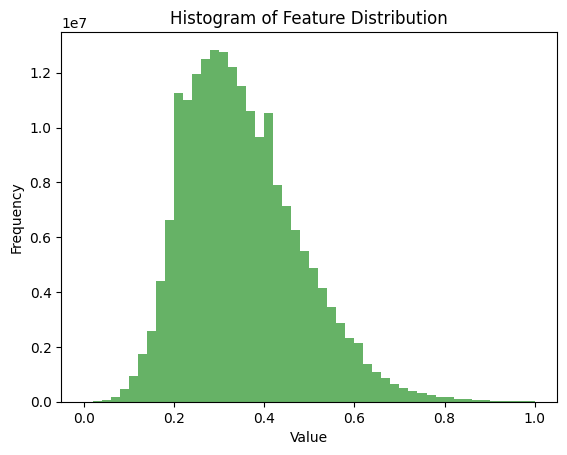

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'data' is your dataset loaded as a 2D numpy array or a PyTorch tensor
# Let's say we want to visualize the distribution of the first feature/column

#feature = flattened_data.numpy()  # Convert to numpy if it's a tensor

plt.hist(flattened_data, bins=50, alpha=0.6, color='g')
plt.title('Histogram of Feature Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
def compute_mean_std(dataloader):
    # Variables for mean and std calculation
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total_images = 0

    for images in dataloader:
        # Stack all data in a batch
        batch_samples = images.size(0)  # batch size (the last batch can have smaller size!)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples

    # Final mean and std
    mean /= total_images
    std /= total_images

    return mean, std

mean, std = compute_mean_std(train_loader)
print(mean, std)

tensor([0.4112, 0.3803, 0.2822]) tensor([0.1094, 0.0850, 0.0718])


In [ ]:
# load to each set
train_set = []
val_set = []
test_set = []

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.ToPILImage(),  # If your images are not in PIL Image format
    transforms.Resize((256, 256)),  # Resizing the image
    transforms.ToTensor(),  # Convert the PIL Image to a tensor
    transforms.Normalize(mean, std)  # Normalize the tensor
])

train_dataset = DataFull(train_info, image_folder_path ,transform=transform)
val_dataset = DataFull(val_info, image_folder_path ,transform=transform)
test_dataset = DataFull(test_info, image_folder_path ,transform=transform)

In [ ]:
train_set = []
val_set = []
test_set = []

for i in range(int(len(train_dataset))):  # Assuming train_dataset is an instance of DataFull
    image = train_dataset[i]  # Use subscript notation
    train_set.append(image)
print("finish train set")

for i in range(int(len(val_info))):
    image = val_dataset[i]  # Use subscript notation
    val_set.append(image)
print("finish val set")

for i in range(int(len(test_info))):
    image = test_dataset[i]  # Use subscript notation
    test_set.append(image)
print("finish test set")

finish train set
finish val set
finish test set


In [ ]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1 ,
                                            shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1,
                                            shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1,
                                            shuffle=True)

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import shapiro

# Example dataset (replace with your actual dataset)
data = torch.randn(1000, 10)  # 1000 samples, each with 10 features, from a normal distribution
labels = torch.zeros(1000)  # Dummy labels

# Creating a TensorDataset and DataLoader
dataset = TensorDataset(data, labels)
data_loader = DataLoader(dataset, batch_size=100, shuffle=True)

# Assuming you want to test the first batch
for batch in data_loader:
    batch_data, batch_labels = batch
    # Flattening the data to 1D
    flattened_data = batch_data.view(-1).numpy()
    break  # We only take the first batch for this example

# Performing the Shapiro-Wilk test
stat, p = shapiro(flattened_data)
print('Statistics=%.3f, p=%.3f' % (stat, p))

# Interpretation
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.999, p=0.637
Sample looks Gaussian (fail to reject H0)


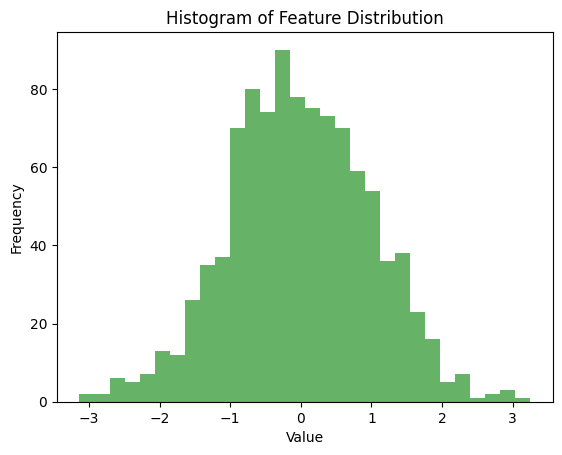

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'data' is your dataset loaded as a 2D numpy array or a PyTorch tensor
# Let's say we want to visualize the distribution of the first feature/column
feature = data[:, 0].numpy()  # Convert to numpy if it's a tensor

plt.hist(feature, bins=30, alpha=0.6, color='g')
plt.title('Histogram of Feature Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()



---



---



---



---



---



---

More Loading Code for input & label

In [ ]:
class DataFull(object):  # Class names typically use CamelCase
    def __init__(self, csv_info, image_folder_path, transform_input=None, transform_output=None):
        self.img_info = csv_info
        self.image_folder_path = image_folder_path
        self.transform_input = transform_input
        self.transform_output = transform_output

    def __len__(self):
        return len(self.img_info)  # Assuming img_info is a DataFrame or similar structure

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder_path, self.img_info['sat_image_path'][idx])
        image = read_image(img_path)
        label_path = os.path.join(self.image_folder_path, self.img_info['mask_path'][idx])
        label = read_image(label_path)
        if self.transform:
            image = self.transform(image)
        return image, label


In [ ]:
class Autoencoder2(nn.Module):
    def __init__(self):
        super(Autoencoder2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.LeakyReLU(True),
            nn.AvgPool2d(2, stride=2, padding=0),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.LeakyReLU(True),
            nn.Conv2d(32, 64, 7),
            nn.AvgPool2d(2, stride=2, padding=0)

        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(True),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
summary(Autoencoder2(), (3, 256, 256))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same


try overfit
---



---



---



---



In [ ]:
!unzip /content/drive/MyDrive/APS360Project/archive/cropped_dataset/A.zip

In [ ]:
# initialization
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
import os
drive.mount('/content/drive')
import numpy as np
import time
import pandas as pd
from matplotlib.image import imread
from torchvision.io import read_image
from torchsummary import summary
import torch.optim as optim

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# path declare
master_path = '/content/drive/MyDrive/APS360Project/archive/cropped_dataset/'
csv_path = master_path + "cropped_proportion.csv"
train_csv_path = master_path + "cropped_proportion_train.csv"
val_csv_path = master_path + "cropped_proportion_valid.csv"
test_csv_path = master_path + "cropped_proportion_test.csv"
class_dict_path = master_path + "class_dict.csv"
image_folder_path = '/content/A'
total_info = pd.read_csv(csv_path)
train_info = pd.read_csv(train_csv_path)
val_info = pd.read_csv(val_csv_path)
test_info = pd.read_csv(test_csv_path)

In [ ]:
print(len(total_info['image_id']))
print(len(train_info['image_id']), len(train_info['image_id'])/len(total_info['image_id']))
print(len(val_info['image_id']), len(val_info['image_id'])/len(total_info['image_id']))
print(len(test_info['image_id']), len(test_info['image_id'])/len(total_info['image_id']))

12848
9616 0.7484433374844334
1616 0.12577833125778332
1616 0.12577833125778332


In [ ]:
class DataFull(object):  # Class names typically use CamelCase
    def __init__(self, csv_info, image_folder_path, transform_input, transform_output):
        self.img_info = csv_info
        self.image_folder_path = image_folder_path
        self.transform_input = transform_input
        self.transform_output = transform_output

    def __len__(self):
        return len(self.img_info)  # Assuming img_info is a DataFrame or similar structure

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder_path, self.img_info['sat_image_path'][idx])
        image = read_image(img_path)
        label_path = os.path.join(self.image_folder_path, self.img_info['mask_path'][idx])
        label = read_image(label_path)
        if self.transform_input:
            image = self.transform_input(image)
        if self.transform_output:
            label = self.transform_output(label)
        return image, label

In [ ]:
mean= [0.4112, 0.3803, 0.2822]
std= [0.1094, 0.0850, 0.0718]
transform_input = transforms.Compose(
        [transforms.ToPILImage(),
         transforms.ToTensor(),
         #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
         transforms.Normalize(mean, std),
         transforms.Resize((256,256))])

transform_output = transforms.Compose(
        [transforms.ToPILImage(),
         transforms.ToTensor(),
         transforms.Resize((256,256))])

train_dataset = DataFull(train_info, image_folder_path, transform_input, transform_output)
val_dataset = DataFull(val_info, image_folder_path, transform_input, transform_output)
test_dataset = DataFull(test_info, image_folder_path,transform_input, transform_output)

In [ ]:
train_set = []
val_set = []
test_set = []

for i in range(int(len(train_info)/5)):  # Assuming train_dataset is an instance of DataFull
    image, label = train_dataset[i]  # Use subscript notation
    train_set.append((image, label))
    print(i)
print("finish train set")

for i in range(int(len(val_info)/3)):
  image, label = val_dataset[i]
  val_set.append((image, label))
print("finish val set")

for i in range(int(len(test_info)/3)):
  image, label = test_dataset[i]
  test_set.append((image, label))
print("finish test set")

In [ ]:
print(len(train_set))
print(len(val_set))
print(len(test_set))

1923
538
538


In [ ]:
print((train_set[20][0]).shape)

torch.Size([3, 256, 256])


In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1 ,
                                            shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1,
                                            shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1,
                                            shuffle=True)

In [ ]:
def model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
import matplotlib.pyplot as plt

def train_autoencoder(autoencoder, num_epochs, train_loader, val_loader, criterion, optimizer, device):
    autoencoder.to(device)
    autoencoder.train()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training
        running_train_loss = 0.0
        total_pixels_train = 0
        correct_pixels_train = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = autoencoder(inputs).to(device)
            batch_loss = criterion(outputs, labels)

            # Backward pass and optimization
            batch_loss.backward()
            optimizer.step()

            running_train_loss += batch_loss.item()

            # Calculate accuracy
            total_pixels_train += inputs.numel()
            correct_pixels_train += torch.sum(torch.abs(outputs - labels) < 0.05).item()

        train_accuracy = correct_pixels_train / total_pixels_train
        train_accuracies.append(train_accuracy)
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        autoencoder.eval()  # Set the model to evaluation mode
        running_val_loss = 0.0
        total_pixels_val = 0
        correct_pixels_val = 0

        with torch.no_grad():
            for inputs_val, labels_val in val_loader:
                inputs_val = inputs_val.to(device)
                labels_val = labels_val.to(device)
                outputs_val = autoencoder(inputs_val).to(device)
                val_loss = criterion(outputs_val, labels_val)
                running_val_loss += val_loss.item()

                # Calculate accuracy
                total_pixels_val += inputs_val.numel()
                correct_pixels_val += torch.sum(torch.abs(outputs_val - labels_val) < 0.05).item()

        val_accuracy = correct_pixels_val / total_pixels_val
        val_accuracies.append(val_accuracy)
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        model_path = "/content/overfit_1/" + model_name("autoencoder", batch_size, learning_rate, epoch)
        # Print statistics
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {avg_val_loss}, Val Accuracy: {val_accuracy}")
        # torch.save(autoencoder.state_dict(), model_path)
        autoencoder.train()

    print("Finished Training")

    #np.savetxt("{}_train_err.csv".format(model_path), train_accuracy)
    #np.savetxt("{}_train_loss.csv".format(model_path), avg_train_loss)
    #np.savetxt("{}_val_err.csv".format(model_path), avg_val_loss)
    # np.savetxt("{}_val_loss.csv".format(model_path), val_accuracy)



    # Plot the loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot the accuracy curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
class Autoencoder2(nn.Module):
    def __init__(self):
        super(Autoencoder2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 16, stride=2, padding=1),
            nn.LeakyReLU(True),
            nn.AvgPool2d(2, stride=2, padding=0),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.LeakyReLU(True),
            nn.AvgPool2d(2, stride=2, padding=0),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(True),
            nn.Conv2d(64, 128, 3),
            nn.AvgPool2d(2, stride=2, padding=0),

        )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.ConvTranspose2d(128, 64, 3),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=0),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(16, 3, 17, stride=2, padding=0, output_padding=1),
            nn.LeakyReLU(True),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
autoencoder = Autoencoder2()
autoencoder.to(device)
summary(autoencoder, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 122, 122]          12,304
         LeakyReLU-2         [-1, 16, 122, 122]               0
         AvgPool2d-3           [-1, 16, 61, 61]               0
            Conv2d-4           [-1, 32, 31, 31]           4,640
         LeakyReLU-5           [-1, 32, 31, 31]               0
         AvgPool2d-6           [-1, 32, 15, 15]               0
            Conv2d-7             [-1, 64, 8, 8]          18,496
         LeakyReLU-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 6, 6]          73,856
        AvgPool2d-10            [-1, 128, 3, 3]               0
         Upsample-11            [-1, 128, 6, 6]               0
  ConvTranspose2d-12             [-1, 64, 8, 8]          73,792
        LeakyReLU-13             [-1, 64, 8, 8]               0
  ConvTranspose2d-14           [-1, 32,

Epoch 1/250, Train Loss: 0.1782145299872414, Train Accuracy: 0.03342914498643748, Val Loss: 0.1746451635571087, Val Accuracy: 0.03342778088878078
Epoch 2/250, Train Loss: 0.15838423359100937, Train Accuracy: 0.05983848525490499, Val Loss: 0.16281152823392084, Val Accuracy: 0.12556080304113906
Epoch 3/250, Train Loss: 0.15591388134682765, Train Accuracy: 0.05321042329811682, Val Loss: 0.1701221606310676, Val Accuracy: 0.03865775447500387
Epoch 4/250, Train Loss: 0.1529114956005675, Train Accuracy: 0.07669891553149105, Val Loss: 0.17596757587264567, Val Accuracy: 0.045015422532697295
Epoch 5/250, Train Loss: 0.15486773714178897, Train Accuracy: 0.061318963378652336, Val Loss: 0.17513582285712748, Val Accuracy: 0.033739385403960466
Epoch 6/250, Train Loss: 0.16206862606474612, Train Accuracy: 0.06296384708578447, Val Loss: 0.17263336611144683, Val Accuracy: 0.056643262671715267
Epoch 7/250, Train Loss: 0.15094118314932603, Train Accuracy: 0.07937946607219758, Val Loss: 0.18335036232190974

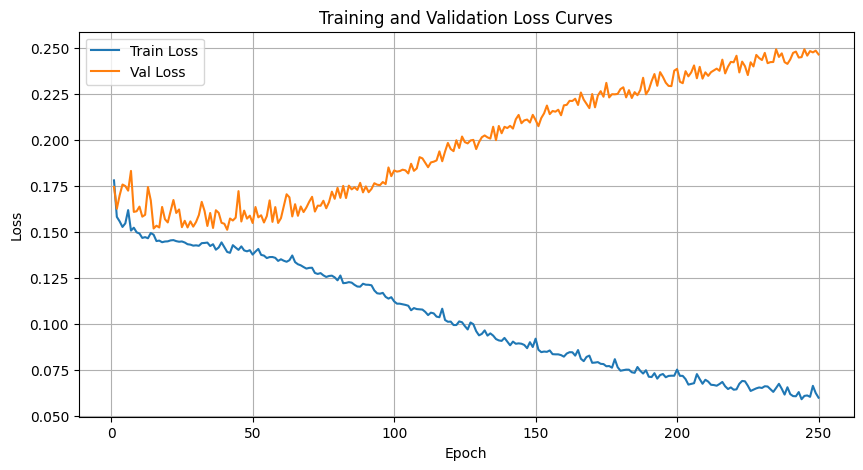

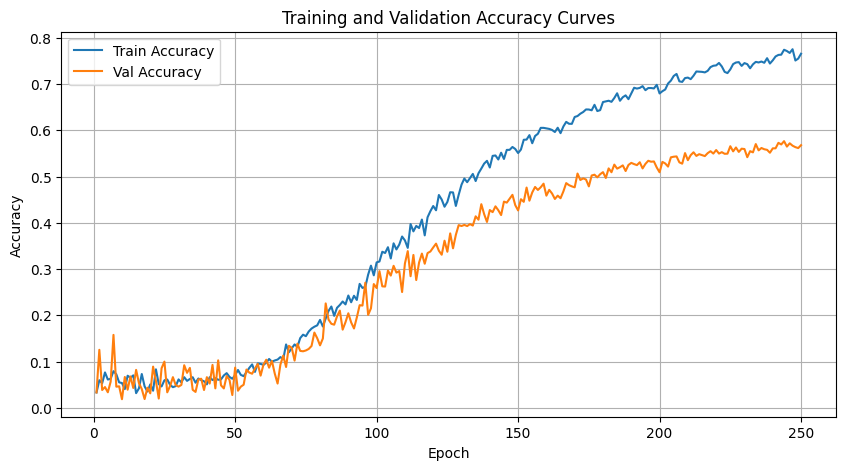

In [ ]:
num_epochs = 250
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

autoencoder = Autoencoder2()  # Instantiate your autoencoder model
criterion = nn.MSELoss()  # Define the loss function
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)  # Define the optimizer

formal_trial_1 = train_autoencoder(autoencoder, num_epochs, train_loader, val_loader, criterion, optimizer, device)

In [ ]:
def output_image(autoencoder, train_loader, device):
    autoencoder.to(device)
    autoencoder.eval()

    # Select an index for the image to visualize
    index = 90

    # Get the image and its reconstruction
    with torch.no_grad():
        inputs, labels = train_set[index]
        inputs = inputs.unsqueeze(0).to(device)
        outputs = autoencoder(inputs)

    input_image = inputs.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    reconstructed_image = outputs.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    mask_image = labels.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()

    # Plot the images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(input_image)
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(reconstructed_image)
    plt.title('Reconstructed Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(mask_image)
    plt.title('Reconstructed Image')
    plt.axis('off')

    plt.show()

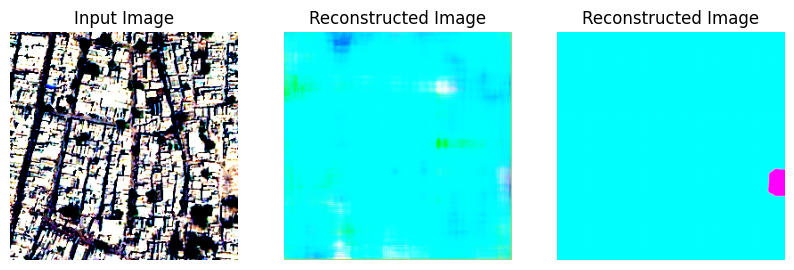

In [ ]:
output_image(autoencoder, train_loader, device)